In [1]:
## Loading Libraries
from __future__ import division
from datetime import datetime, timedelta,date
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from pandas import Series
from pandas import DataFrame
import warnings
warnings.filterwarnings("ignore")
import chart_studio.plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import acf
from scipy import stats
from scipy.stats import normaltest
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.layers import LSTM
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import r2_score
#initiate plotly
pyoff.init_notebook_mode()

Using TensorFlow backend.


In [2]:
#read the data in csv
df1 = pd.read_csv('Data/MSK_WHS1_FY19_P3.csv')
df2 = pd.read_csv('Data/MSK_WHS1_FY19_P5.csv')
df3 = pd.read_csv('Data/MSK_WHS1_FY19_P8.csv')
store_data1 = pd.concat([df1, df2, df3], ignore_index=True)

In [3]:
#convert date field from string to datetime
store_data = store_data1.copy()
store_data['date'] = pd.to_datetime(store_data['MBDATE'])
def convert(p):
    if len(p[:-2]) == 0:
        return '00'+':'+'00'+':00'
    elif len(p[:-2]) == 1:
        return '0'+p[:-2]+':'+'00'+':00'
    else:
        return p[:-2]+':'+'00'+':00'
store_data['MBTIME'] = store_data['MBTIME'].apply(str).map(lambda p: convert(p))
store_data['MBDATE'] = pd.to_datetime(store_data['MBDATE'])

# Groupby date and sum the sales
store_data['MBTIME'] = pd.to_timedelta(store_data['MBTIME'])
store_data['MBDATETIME'] = pd.to_datetime(store_data['MBDATE']+store_data['MBTIME'])
store_data.head(-5)

store_data

MBWHSE     MBDATE    MBMBRN  MBDEPT   MBITEM  MBREG_NUM  MBTRN_NUM  \
0             1 2018-10-05  33335737      17   972150          6        435   
1             1 2018-11-18  12430582      65    39054          6        244   
2             1 2018-11-18  12430582      61    29755          6        244   
3             1 2018-11-18  12430582      13   654679          6        244   
4             1 2018-09-29  12430582      65    57554          3        314   
...         ...        ...       ...     ...      ...        ...        ...   
2046044       1 2019-04-04  12426944      27  1273473          8         15   
2046045       1 2019-04-04  12426944      14  1218587          8         15   
2046046       1 2019-02-21  12422030      23  1200261         83         10   
2046047       1 2019-03-07  12425967      13   980999          7        309   
2046048       1 2019-03-29  12422030      65    57554         11        227   

          MBTIME  MBSELL  MBDSUN  ...  FISCAL_PERIOD  IMCAT1  \
0       19:00:00   14.49       1  ...              2       C   
1       15:00:00    4.79       1  ...              3       1   
2       15:00:00    5.99       1  ...              3       6   
3       15:00:00   10.99       1  ...              3       K   
4       16:00:00    6.99       1  ...              1       1   
...          ...     ...     ...  ...            ...     ...   
2046044 10:00:00    8.99       1  ...              8       R   
2046045 10:00:00   14.89       1  ...              8       D   
2046046 10:00:00   12.99      -1  ...              7       U   
2046047 17:00:00    6.89       1  ...              7       J   
2046048 14:00:00    6.99       1  ...              8       1   

                            IMDES1                     IMDES2 IMCAT2 IMCAT3  \
0          NAKED VTY SMTH 12/10 OZ  DOM 90/SL 50    T26H7P182      A      A   
1             PERUVIAN SWEET ONION                        NaN      O      1   
2          LAMB LEG BONELESS ROAST                  AUSTRALIA      7      0   
3        ORG QUINOA BR RICE 6/8.5Z   SEEDS OF CHANGE L240P264      A      B   
4                      BLUEBERRIES                      18 OZ      B      0   
...                            ...                        ...    ...    ...   
2046044    KELLOGG ORGANIC POTTING   SOIL   55 QT  FY19   P36      A      A   
2046045      SWIFFER DUSTERS 28 CT     W/ HANDLE  T42H6P252 D      S      S   
2046046         FEIT LED 60W 6PK D   DAYLIGHT           P 336      G      A   
2046047   NISSIN BEEF CUP 24/2.5OZ   CUP O NOODLES  T10H5 P50      A      C   
2046048                BLUEBERRIES                      18 OZ      B      0   

                            CDDESC M2EXCFLG       date          MBDATETIME  
0               PASTEURIZED JUICES        N 2018-10-05 2018-10-05 19:00:00  
1                            SWEET        E 2018-11-18 2018-11-18 15:00:00  
2                             LAMB        E 2018-11-18 2018-11-18 15:00:00  
3                 PREPARED   BOXED        E 2018-11-18 2018-11-18 15:00:00  
4                      BLUEBERRIES        E 2018-09-29 2018-09-29 16:00:00  
...                            ...      ...        ...                 ...  
2046044           SOIL POTTING MIX        E 2019-04-04 2019-04-04 10:00:00  
2046045  CLEAN SUPPLIES NOT FLOORS        E 2019-04-04 2019-04-04 10:00:00  
2046046            LED LIGHT BULBS        N 2019-02-21 2019-02-21 10:00:00  
2046047        SOUP BOWLS AND CUPS        N 2019-03-07 2019-03-07 17:00:00  
2046048                BLUEBERRIES        N 2019-03-29 2019-03-29 14:00:00  

[2046049 rows x 22 columns]

In [4]:
## Filtering the records between 9AM to 6PM
mask = (store_data['MBTIME'] > pd.to_timedelta('09:00:00')) & (store_data['MBTIME'] <= pd.to_timedelta('19:00:00'))
store_data = store_data.loc[mask]
store_data

MBWHSE     MBDATE    MBMBRN  MBDEPT   MBITEM  MBREG_NUM  MBTRN_NUM  \
0             1 2018-10-05  33335737      17   972150          6        435   
1             1 2018-11-18  12430582      65    39054          6        244   
2             1 2018-11-18  12430582      61    29755          6        244   
3             1 2018-11-18  12430582      13   654679          6        244   
4             1 2018-09-29  12430582      65    57554          3        314   
...         ...        ...       ...     ...      ...        ...        ...   
2046044       1 2019-04-04  12426944      27  1273473          8         15   
2046045       1 2019-04-04  12426944      14  1218587          8         15   
2046046       1 2019-02-21  12422030      23  1200261         83         10   
2046047       1 2019-03-07  12425967      13   980999          7        309   
2046048       1 2019-03-29  12422030      65    57554         11        227   

          MBTIME  MBSELL  MBDSUN  ...  FISCAL_PERIOD  IMCAT1  \
0       19:00:00   14.49       1  ...              2       C   
1       15:00:00    4.79       1  ...              3       1   
2       15:00:00    5.99       1  ...              3       6   
3       15:00:00   10.99       1  ...              3       K   
4       16:00:00    6.99       1  ...              1       1   
...          ...     ...     ...  ...            ...     ...   
2046044 10:00:00    8.99       1  ...              8       R   
2046045 10:00:00   14.89       1  ...              8       D   
2046046 10:00:00   12.99      -1  ...              7       U   
2046047 17:00:00    6.89       1  ...              7       J   
2046048 14:00:00    6.99       1  ...              8       1   

                            IMDES1                     IMDES2 IMCAT2 IMCAT3  \
0          NAKED VTY SMTH 12/10 OZ  DOM 90/SL 50    T26H7P182      A      A   
1             PERUVIAN SWEET ONION                        NaN      O      1   
2          LAMB LEG BONELESS ROAST                  AUSTRALIA      7      0   
3        ORG QUINOA BR RICE 6/8.5Z   SEEDS OF CHANGE L240P264      A      B   
4                      BLUEBERRIES                      18 OZ      B      0   
...                            ...                        ...    ...    ...   
2046044    KELLOGG ORGANIC POTTING   SOIL   55 QT  FY19   P36      A      A   
2046045      SWIFFER DUSTERS 28 CT     W/ HANDLE  T42H6P252 D      S      S   
2046046         FEIT LED 60W 6PK D   DAYLIGHT           P 336      G      A   
2046047   NISSIN BEEF CUP 24/2.5OZ   CUP O NOODLES  T10H5 P50      A      C   
2046048                BLUEBERRIES                      18 OZ      B      0   

                            CDDESC M2EXCFLG       date          MBDATETIME  
0               PASTEURIZED JUICES        N 2018-10-05 2018-10-05 19:00:00  
1                            SWEET        E 2018-11-18 2018-11-18 15:00:00  
2                             LAMB        E 2018-11-18 2018-11-18 15:00:00  
3                 PREPARED   BOXED        E 2018-11-18 2018-11-18 15:00:00  
4                      BLUEBERRIES        E 2018-09-29 2018-09-29 16:00:00  
...                            ...      ...        ...                 ...  
2046044           SOIL POTTING MIX        E 2019-04-04 2019-04-04 10:00:00  
2046045  CLEAN SUPPLIES NOT FLOORS        E 2019-04-04 2019-04-04 10:00:00  
2046046            LED LIGHT BULBS        N 2019-02-21 2019-02-21 10:00:00  
2046047        SOUP BOWLS AND CUPS        N 2019-03-07 2019-03-07 17:00:00  
2046048                BLUEBERRIES        N 2019-03-29 2019-03-29 14:00:00  

[1977556 rows x 22 columns]

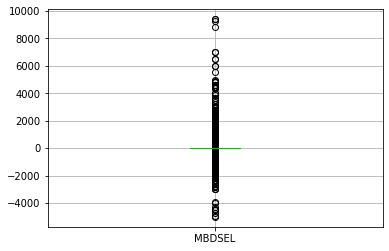

In [5]:
## Removing Outliers
mask = (store_data['MBDSEL'] > -5000) & (store_data['MBDSEL'] <= 10000)
store_data = store_data.loc[mask]
store_data.boxplot(column=['MBDSEL'])

In [6]:
## Group by Hour
store_sales = store_data.copy()
store_sales['SALES'] = store_sales['MBDSEL'].groupby([store_sales.MBDATETIME.dt.year, store_sales.MBDATETIME.dt.month, store_sales.MBDATETIME.dt.day, store_sales.MBDATETIME.dt.hour]).transform('sum')
store_sales = store_sales[['MBDATETIME', 'SALES']]
store_sales.head(10)

MBDATETIME     SALES
0 2018-10-05 19:00:00   9606.73
1 2018-11-18 15:00:00  21863.69
2 2018-11-18 15:00:00  21863.69
3 2018-11-18 15:00:00  21863.69
4 2018-09-29 16:00:00  10850.02
5 2018-10-20 11:00:00  18036.02
6 2018-11-19 19:00:00  13156.86
7 2018-10-09 13:00:00  14920.43
8 2018-09-05 11:00:00  23042.08
9 2018-09-05 11:00:00  23042.08

In [7]:
## Bi-Hourly Grouping
store_sales = store_sales.drop_duplicates(['MBDATETIME']).sort_values(by='MBDATETIME').reset_index()[['MBDATETIME','SALES']]
store_sales = store_sales.groupby(store_sales.MBDATETIME.dt.floor('2H')).sum().reset_index()
store_sales

MBDATETIME     SALES
0    2018-09-04 10:00:00  33369.83
1    2018-09-04 12:00:00  33019.61
2    2018-09-04 14:00:00  30972.80
3    2018-09-04 16:00:00  25300.54
4    2018-09-04 18:00:00  19943.28
...                  ...       ...
1094 2019-04-14 10:00:00  30129.10
1095 2019-04-14 12:00:00  29918.94
1096 2019-04-14 14:00:00  33666.59
1097 2019-04-14 16:00:00  29161.57
1098 2019-04-14 18:00:00   6169.86

[1099 rows x 2 columns]

In [8]:
# Changing the column names
store_sales.columns = ['date', 'sales']
store_sales.head(2)
store_sales.to_csv('sales-by-hour.csv')

In [9]:
## Data processing for ARIMA
data_arima = store_sales.copy()
data_arima['year'] = data_arima['date'].dt.year
data_arima['month'] = data_arima['date'].dt.month
data_arima['day'] = data_arima['date'].dt.dayofyear
data_arima['weekday'] = data_arima['date'].dt.weekday
data_arima.head()

date     sales  year  month  day  weekday
0 2018-09-04 10:00:00  33369.83  2018      9  247        1
1 2018-09-04 12:00:00  33019.61  2018      9  247        1
2 2018-09-04 14:00:00  30972.80  2018      9  247        1
3 2018-09-04 16:00:00  25300.54  2018      9  247        1
4 2018-09-04 18:00:00  19943.28  2018      9  247        1

## **Data Exploration**

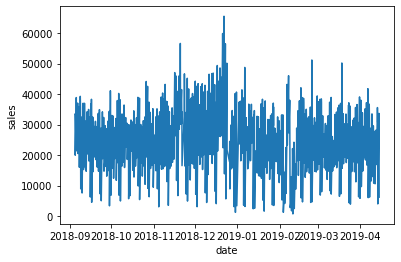

In [10]:
# Plot of Sales
sns.lineplot(x="date", y="sales",legend = 'full' , data=data_arima)

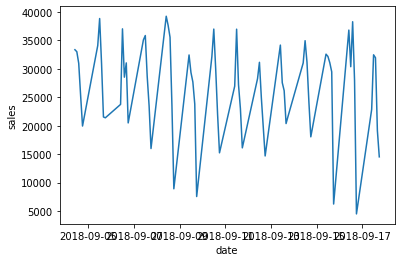

In [11]:
## Plot of Sales of first two weeks for observing seasonility
sns.lineplot(x="date", y="sales",legend = 'full' , data=data_arima[:70])

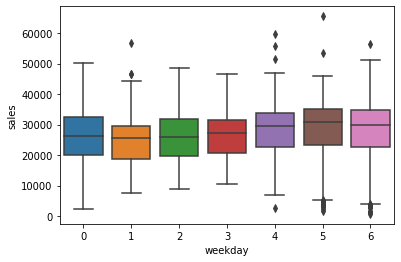

In [12]:
## Box plot of sales according to weekday
sns.boxplot(x="weekday", y="sales", data=data_arima)

In [13]:
## Setting Date as index.
data_arima = data_arima.set_index('date')
data_arima['sales'] = data_arima['sales'].astype(float)
data_arima.head()

sales  year  month  day  weekday
date                                                    
2018-09-04 10:00:00  33369.83  2018      9  247        1
2018-09-04 12:00:00  33019.61  2018      9  247        1
2018-09-04 14:00:00  30972.80  2018      9  247        1
2018-09-04 16:00:00  25300.54  2018      9  247        1
2018-09-04 18:00:00  19943.28  2018      9  247        1

<Figure size 432x288 with 0 Axes>

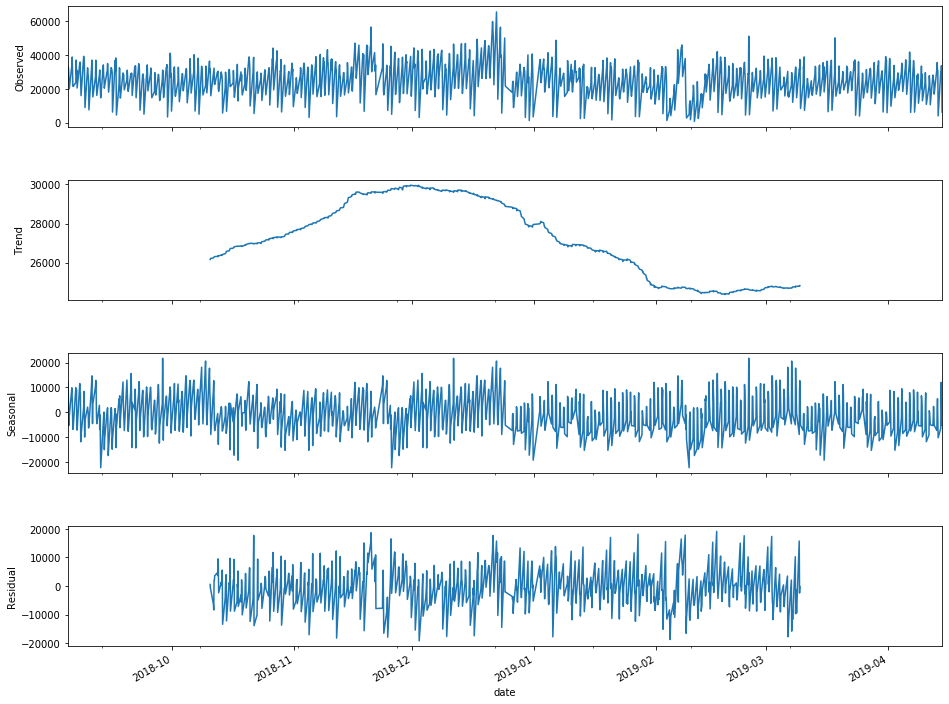

In [14]:
## Visulizing the trends in the data
result = seasonal_decompose(data_arima['sales'], model='additive', freq=365)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 12)

## **Stationarize the data:** 
The mean and the variance of the series should not be a function of time.

**Importance of Data Stationary:** Most statistical forecasting methods are based on the assumption that the time series can be rendered approximately stationary (i.e., "stationarized") through the use of mathematical transformations. A stationarized series is relatively easy to predict.

**Test for Data Stationary:**
In time series, the data stationary can be checked in two methods, Data visulization an Statistical tests. In the first technique, sationrity of the series can be identified from a changing mean or variation in the data. However, the later approach, Statistical test(Dickey-Fuller test) to be implemented for a more accurate assessment. The null hypothesis of the test is that a unit root is preent in the time series sample (i.e., The time series is not stationary.)

In [16]:
## Function for checking data stationary

def test_stationarity(timeseries, window = 12, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

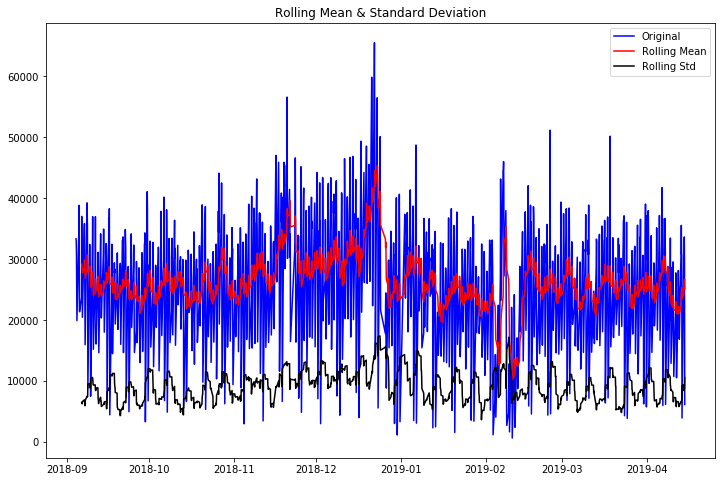

Results of Dickey-Fuller Test:
p-value = 0.0001. The series is likely stationary.
Test Statistic                   -4.713781
p-value                           0.000079
#Lags Used                       20.000000
Number of Observations Used    1078.000000
Critical Value (1%)              -3.436431
Critical Value (5%)              -2.864225
Critical Value (10%)             -2.568200
dtype: float64


In [17]:
test_stationarity(data_arima['sales'])

The smaller p-value (0.000079) suggests that the data is stationary (i.e., Null hypothesis is rejected). But from the Data visulization we can see that the mean of the series is varing wit the time. So, to get morre accurate results, first order differencing can be applied on the series.

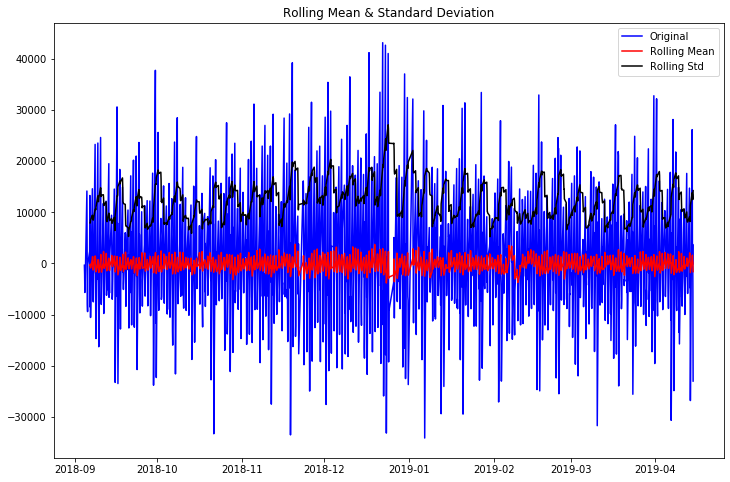

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -1.106269e+01
p-value                        4.765530e-20
#Lags Used                     1.900000e+01
Number of Observations Used    1.078000e+03
Critical Value (1%)           -3.436431e+00
Critical Value (5%)           -2.864225e+00
Critical Value (10%)          -2.568200e+00
dtype: float64


In [18]:
## Checking Data stationary after first order differencing
first_diff = data_arima.sales - data_arima.sales.shift(1)
first_diff = first_diff.dropna(inplace = False)
test_stationarity(first_diff, window = 12)

Post transformation, both the visuliation and Dickey- fuller test suggest that the series is likely stationary.

# **AR and MA terms**
The AR and MA terms of the model can be determined by the plotting ACF and PACF graphs.


**Auto Regression**

ACF describes the autocorrelation between an observation and another observation at a prior time step that includes direct and indirect dependence information.

ACF for the AR(k) time series to be strong to a lag of k and the inertia of that relationship would carry on to subsequent lag values, trailing off at some point as the effect was weakened.

PACF describes the direct relationship between an observation and its lag. This would suggest that there would be no correlation for lag values beyond k.

**Moving Average**

The moving average process is an autoregression model of the time series of residual errors from prior predictions. In othe words, the moving average model is that it corrects future forecasts based on errors made on recent forecasts.

ACF for the MA(k) process will show a strong correlation with recent values up to the lag of k, then a sharp decline to low or no correlation. 
 PACF plot will show a strong relationship to the lag and a trailing off of correlation from the lag onwards.


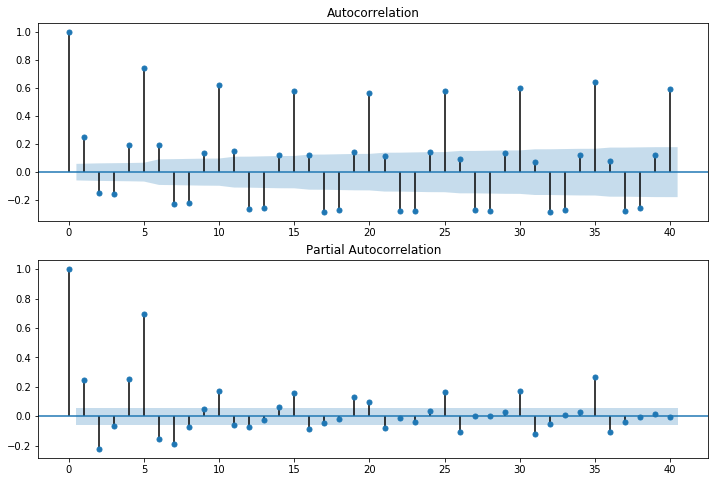

In [19]:
## Plotting ACF and PACF graphs.
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data_arima.sales, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data_arima.sales, lags=40, ax=ax2)

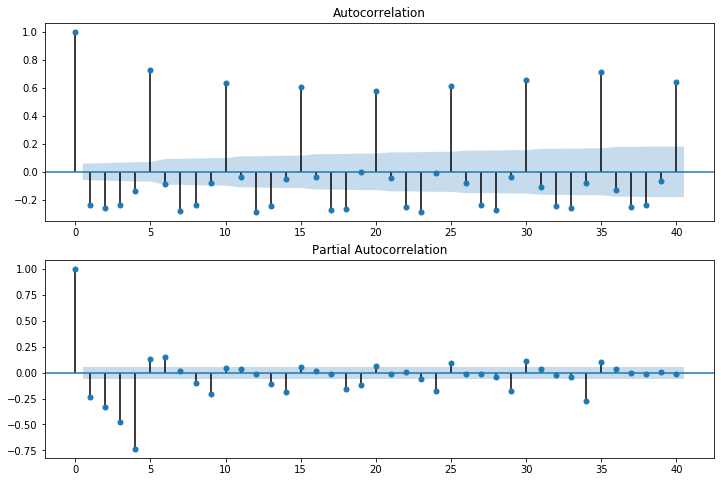

In [20]:
## Plotting ACF and PACF graphs for first order differenced data.
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(first_diff, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(first_diff, lags=40, ax=ax2)

## **Parameters of the model**

AR model to be investigated first with lag length selected from the PACF or via empirical investigation. In this case, the AR is significant within 6 lags. So, AR = 4

As we have transformed the series to the first order differencing, the I term is considered as 1.

To avoid the potential for incorrectly specifying the MA order (in this case where the MA is first tried then the MA order is being set to 5), it may often make sense to extend the lag observed from the last significant term in the PACF.


In [21]:
## inspecting the shape of the data
series = store_sales.copy()
series.shape

(1099, 2)

In [22]:
## Function for calculating forecasting results
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(forecast-actual)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})


## **Model Fitting**

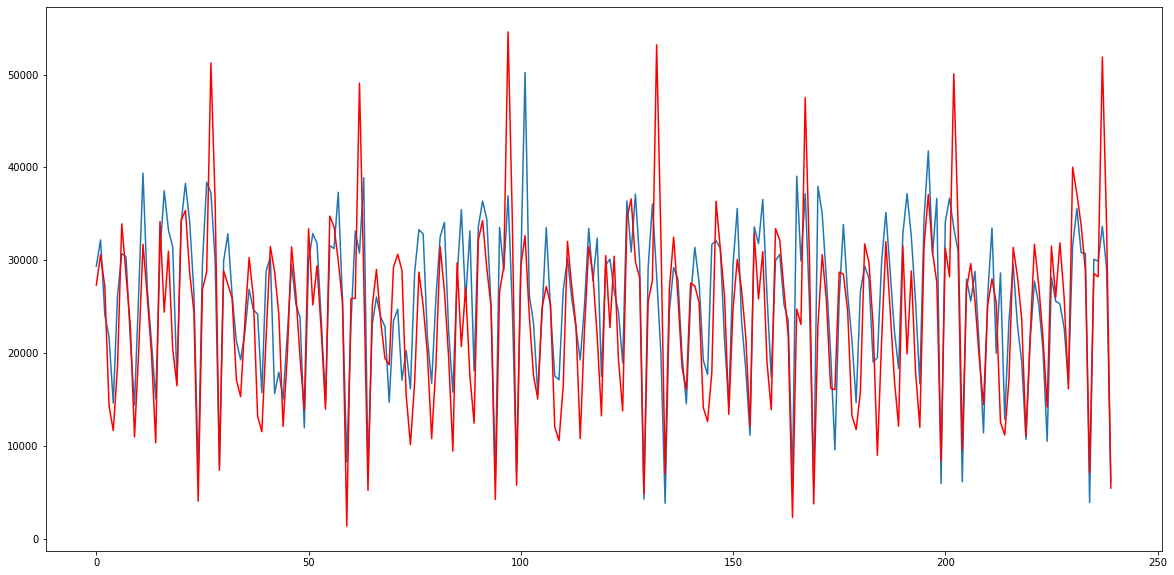

In [23]:
from pandas import read_csv
def parser(x):
	return datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return np.array(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# load dataset
series = read_csv('sales-by-hour.csv', header=0, parse_dates=[1], index_col=1, squeeze=True,date_parser=parser)
series.drop(series.columns[[0]], axis = 1, inplace = True)
train_data, test_data = series[0:-240], series[-240:]
test=test_data['sales'].values
test=test.reshape(test.shape[0],1)
predictions = list()
# seasonal difference
X = train_data.values
days_in_year = 35
differenced = difference(X, days_in_year)
# fit model
model = ARIMA(differenced, order=(4,0,5))
model_fit = model.fit(disp=0)
# multi-step out-of-sample forecast
start_index = 0
end_index = 0 + len(test_data)-1
forecast = model_fit.predict(start=start_index, end=end_index)
# invert the differenced forecast to something usable
history = [x for x in X]
day = 1
for yhat in forecast:
    inverted = inverse_difference(history, yhat, days_in_year)
    #print('Hour %d: %f' % (day, inverted))
    predictions.append(inverted)
    history.append(inverted)
    day += 1
fig= plt.figure(figsize=(20,10))
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [24]:
# Changing the shape of results
res = []
for i in predictions:
    res.append(*i)
res2 = []
for i in test:
    res2.append(*i)
dates_plot = test_data.reset_index()['date'].values
pred_data = {'date':dates_plot , 'actual': res2}

# Placing the data in DataFrame
prediction_df = pd.DataFrame(data=pred_data)
test_data = {'date':dates_plot , 'pred': res}
test_df = pd.DataFrame(data=test_data)
df_sales_pred = pd.merge(test_df,prediction_df,on='date',how='left')
df_sales_pred

date          pred    actual
0   2019-02-26 10:00:00  27344.548116  29378.48
1   2019-02-26 12:00:00  30613.170259  32210.20
2   2019-02-26 14:00:00  27233.748103  24185.08
3   2019-02-26 16:00:00  14360.690900  21732.91
4   2019-02-26 18:00:00  11696.343498  14659.87
..                  ...           ...       ...
235 2019-04-14 10:00:00  28610.406764  30129.10
236 2019-04-14 12:00:00  28235.596156  29918.94
237 2019-04-14 14:00:00  51870.507240  33666.59
238 2019-04-14 16:00:00  33716.409671  29161.57
239 2019-04-14 18:00:00   5519.406084   6169.86

[240 rows x 3 columns]

In [25]:

#plot sales diff
plot_data = [
     go.Scatter(
        x=df_sales_pred['date'],
        y=df_sales_pred['actual'],
        name='actual'
    ),
        go.Scatter(
        x=df_sales_pred['date'],
        y=df_sales_pred['pred'],
        name='predicted'
    )
]
plot_layout = go.Layout(
        title='Montly Sales Diff'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

## **Results**

In [26]:
## Model Results
forecast_accuracy(pd.Series(res), pd.Series(res2))

{'mape': 0.1987054557492886,
 'me': -1431.9055558301586,
 'mae': 4697.677582102062,
 'mpe': -0.04660514671810685,
 'rmse': 6277.052828675905,
 'acf1': 0.11133977776852749,
 'corr': 0.7707303263161397,
 'minmax': 0.1783197601564822}

In [27]:
## Model Summary
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  824
Model:                     ARMA(4, 5)   Log Likelihood               -8489.743
Method:                       css-mle   S.D. of innovations           7212.753
Date:                Sat, 25 Apr 2020   AIC                          17001.487
Time:                        20:36:15   BIC                          17053.343
Sample:                             0   HQIC                         17021.380
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -91.1819    797.298     -0.114      0.909   -1653.857    1471.494
ar.L1.y        0.2896      0.124      2.326      0.020       0.046       0.534
ar.L2.y        0.1068      0.131      0.816      0.4

NormaltestResult(statistic=46.15540697248679, pvalue=9.494688497202881e-11)


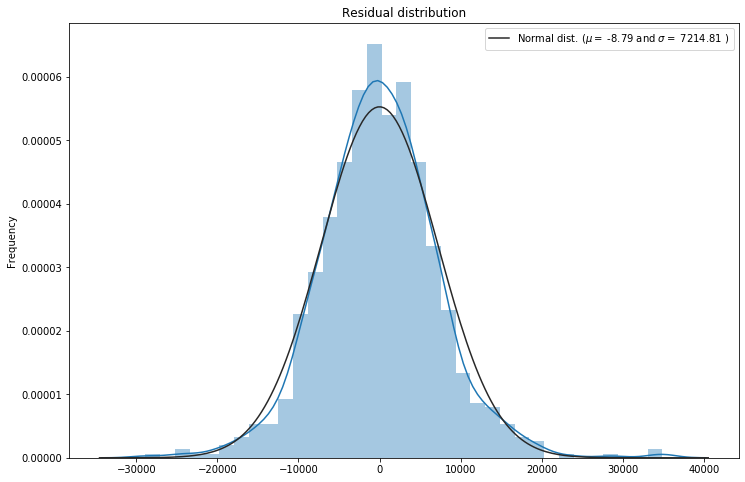

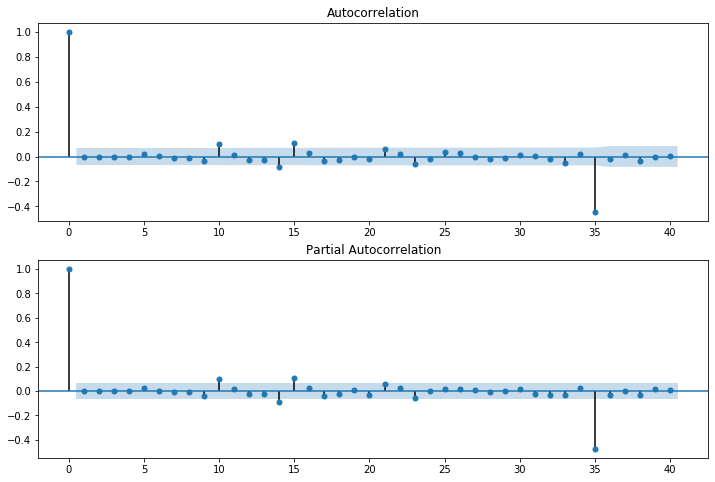

In [28]:
## Analysing the residuals
resid = model_fit.resid
print(normaltest(resid))
# returns a 2-tuple of the chi-squared statistic, and the associated p-value. the p-value is very small, meaning
# the residual is not a normal distribution

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')

# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(model_fit.resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(model_fit.resid, lags=40, ax=ax2)

**Analysis of Results**

The residuals are distributed normally, centered at 0 and exhibits minimum correlation amog them which says that the model is best fit.

## **Forecast for Next 3 Weeks** 

In [29]:
# load dataset
series = read_csv('sales-by-hour.csv', header=0, parse_dates=[1], index_col=1, squeeze=True,date_parser=parser)
series.drop(series.columns[[0]], axis = 1, inplace = True)
# seasonal difference
X = series.values
days_in_year = 70
differenced = difference(X, days_in_year)
predicted = list()
# fit model
model = ARIMA(differenced, order=(4,0,5))
model_fit = model.fit(disp=0)
# multi-step out-of-sample forecast
start_index = len(differenced)
end_index = start_index + 104
forecast = model_fit.predict(start=start_index, end=end_index)
# invert the differenced forecast to something usable
history = [x for x in X]
day = 1
for yhat in forecast:
    inverted = inverse_difference(history, yhat, days_in_year)
    ##print('Hour %d: %f' % (day, inverted))
    predicted.append(inverted)
    history.append(inverted)
    day += 1

In [30]:
## Function for generating dates
def generate_dates(weeks):
    pred_dates = list()
    pred_dates.append(series.reset_index()['date'][len(series)-1])
    weeks = weeks
    date_range = weeks*7*5
    for i in range(0,date_range):
        if i % 5 == 0:
            pred_dates.append(pred_dates[len(pred_dates)-1] + timedelta(hours=16))
        else:
            pred_dates.append(pred_dates[len(pred_dates)-1] + timedelta(hours=2))
    pred_dates.pop(0)
    return(pred_dates)

In [31]:
from statsmodels.tsa.stattools import acf
res = []
for i in predicted:
    res.append(*i)
pred_data = {'date': generate_dates(3), 'sales': res}
prediction_df = pd.DataFrame(data=pred_data)
prediction_df

date         sales
0   2019-04-15 10:00:00  35316.304132
1   2019-04-15 12:00:00  34264.520116
2   2019-04-15 14:00:00  28172.623713
3   2019-04-15 16:00:00  21898.003871
4   2019-04-15 18:00:00   9398.374974
..                  ...           ...
100 2019-05-05 10:00:00  33170.602602
101 2019-05-05 12:00:00  36430.674131
102 2019-05-05 14:00:00  33970.732443
103 2019-05-05 16:00:00  31295.555915
104 2019-05-05 18:00:00   5589.195324

[105 rows x 2 columns]

In [32]:
#plot forecatesd values 
series = series.reset_index()
prediction_df.to_csv('predictions_ARIMA.csv')
plot_data = [
    go.Scatter(
        x=series['date'],
        y=series['sales'],
        name='actual'
    ),
        go.Scatter(
        x=prediction_df['date'],
        y=prediction_df['sales'],
        name='forecast'
    )
    
]
plot_layout = go.Layout(
        title='Sales Prediction'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)